# Chapter 6 - Linear Model Selection and Regularization

[6.2 Shrinkage Methods](#6.2-Shrinkage-Methods)
> [6.2.1 Ridge Regression](#6.2.1-Ridge-Regression)<br>
> [6.2.2 The Lasso](#6.2.2-The-Lasso)<br>
> [6.2.3 Selecting the Tuning Parameter](#6.2.3-Selecting-the-Tuning-Parameter)

[6.3 Dimension Reduction Methods](#6.3-Dimension-Reduction-Methods)
> [6.3.1 Principal Components Regression](#6.3.1-Principal-Components-Regression)

[6.5 Lab 1: Subset Selection Methods](#6.5-Lab-1:-Subset-Selection-Methods)


In [87]:
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from itertools import combinations

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
df_credit = pd.read_csv('Data/Credit.csv', index_col=0)
df_credit["Gender"] = df_credit["Gender"].astype('category')
df_credit["Student"] = df_credit["Student"].astype('category')
df_credit["Married"] = df_credit["Married"].astype('category')
df_credit["Ethnicity"] = df_credit["Ethnicity"].astype('category')
df_credit.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [3]:
df_credit.describe(include='category')

,Gender,Student,Married,Ethnicity
count,400,400,400,400
unique,2,2,2,3
top,Female,No,Yes,Caucasian
freq,207,360,245,199


In [4]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 11 columns):
Income       400 non-null float64
Limit        400 non-null int64
Rating       400 non-null int64
Cards        400 non-null int64
Age          400 non-null int64
Education    400 non-null int64
Gender       400 non-null category
Student      400 non-null category
Married      400 non-null category
Ethnicity    400 non-null category
Balance      400 non-null int64
dtypes: category(4), float64(1), int64(6)
memory usage: 26.9 KB


## 6.2 Shrinkage Methods

In [5]:
y = df_credit.Balance

X = df_credit[df_credit.columns.difference(['Balance'])]
# Use K-1 columns for K categories so Yes/No uses only one column 0/1
X = pd.get_dummies(X, drop_first=True)
X_scaled = scale(X)
X.head(3)

,Age,Cards,Education,Income,Limit,Rating,Ethnicity_Asian,Ethnicity_Caucasian,Gender_Female,Married_Yes,Student_Yes
1,34,2,11,14.891,3606,283,0,1,0,1,0
2,82,3,15,106.025,6645,483,1,0,1,1,1
3,71,4,11,104.593,7075,514,1,0,0,0,0


### 6.2.1 Ridge Regression

In [6]:
n_lambdas = 200
lambdas = np.logspace(5, -2, n_lambdas)

coefs = []
scores = []
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    # it's very important to scale the data for Ridge regression
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)
    scores.append(ridge.score(X_scaled, y))

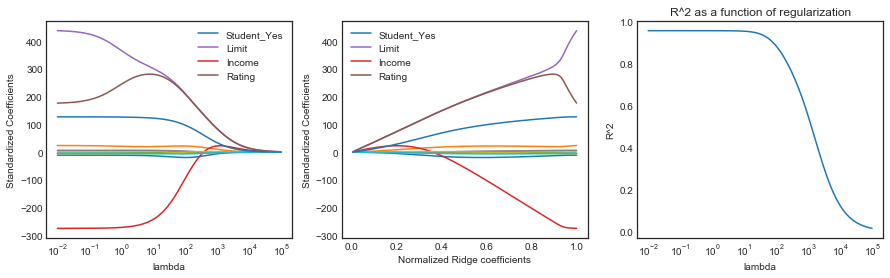

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind])

# second plot
no_ridge_norm = linalg.norm(coefs[-1])
norm_coefs = linalg.norm(coefs/no_ridge_norm, axis=1)
ax2.plot(norm_coefs, coefs)
ax2.set_xlabel('Normalized Ridge coefficients')
ax2.set_ylabel('Standardized Coefficients')
ax2.legend(np.array(ax2.get_lines())[ind], X.columns[ind]);

# third
ax3.plot(lambdas, scores)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('R^2')
ax3.set_title('R^2 as a function of regularization');

### 6.2.2 The Lasso

In [8]:
n_lambdas = 200
lambdas = np.logspace(3, 0.5, n_lambdas)

coefs = []
scores = []
for lam in lambdas:
    lasso = Lasso(alpha=lam)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)
    scores.append(lasso.score(X_scaled, y))

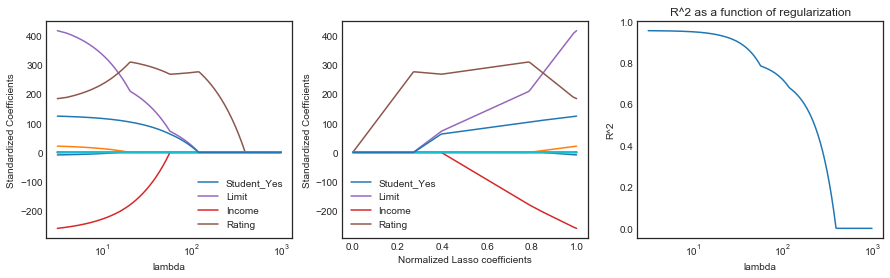

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind])

# second plot
no_lasso_norm = linalg.norm(coefs[-1], ord=1)
norm_coefs = linalg.norm(coefs/no_lasso_norm, axis=1, ord=1)
ax2.plot(norm_coefs, coefs)
ax2.set_xlabel('Normalized Lasso coefficients')
ax2.set_ylabel('Standardized Coefficients')
ax2.legend(np.array(ax2.get_lines())[ind], X.columns[ind]);

# third
ax3.plot(lambdas, scores)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('R^2')
ax3.set_title('R^2 as a function of regularization');

# the values for lambda are different here than in the text
# most likely the function that is minimized is a bit different in scikit-learn and R
# there's probably a factor of N or 2N (N=len(y)) difference.

### 6.2.3 Selecting the Tuning Parameter

In [10]:
lambdas = np.logspace(0.5, -4, 100)
ridgeCV = RidgeCV(alphas=lambdas, store_cv_values=True)
ridgeCV.fit(X_scaled, y)
MSE_alphas = np.mean(ridgeCV.cv_values_, axis=0)

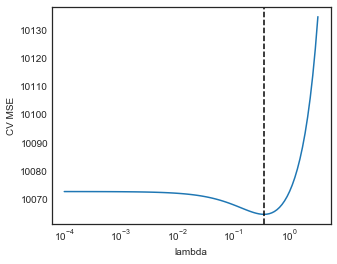

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(lambdas, MSE_alphas)
ax.axvline(ridgeCV.alpha_, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel('lambda')
ax.set_ylabel('CV MSE');

## 6.3 Dimension Reduction Methods

### 6.3.1 Principal Components Regression

In [12]:
components = list(range(1, X_scaled.shape[1]+1))
coefs = []
scores = []
for comp in components:
    pca = PCA(n_components=comp)
    X_pca_comp = pca.fit_transform(X_scaled)
    # use the first comp components
    #X_pca_comp = X_pca[:, 0:comp+1]
    linear = LinearRegression(fit_intercept=False)
    linear.fit(X_pca_comp, y)
    coefs.append(linear.coef_)
    scores.append(linear.score(X_pca_comp, y))

In [13]:
import itertools
coefs = np.array(list(itertools.zip_longest(*coefs, fillvalue=0))).T

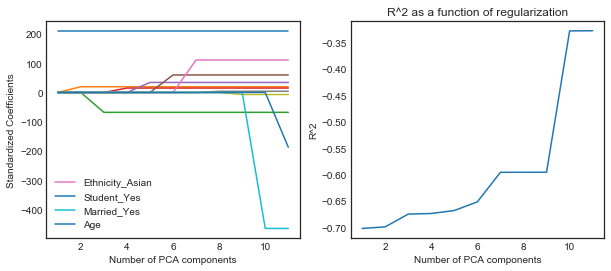

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(components, coefs)
ax1.set_xlabel('Number of PCA components')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind])

# third
ax2.plot(components, scores)
ax2.set_xlabel('Number of PCA components')
ax2.set_ylabel('R^2')
ax2.set_title('R^2 as a function of regularization');

# i'm not sure what Figure 6.20 is displaying
# this is not the same

## 6.5 Lab 1: Subset Selection Methods

In [15]:
df_hitters = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df_hitters.index.name = 'Player'
df_hitters.index = df_hitters.index.map(lambda x: x.replace('-', '', 1))
df_hitters["League"] = df_hitters["League"].astype('category')
df_hitters["Division"] = df_hitters["Division"].astype('category')
df_hitters["NewLeague"] = df_hitters["NewLeague"].astype('category')

In [16]:
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [17]:
len(df_hitters)

263

### 6.5.1 Best Subset Selection

In [88]:
def best_subset(estimator, X, y, max_size=8, cv=5):
    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            estimator.fit(X.iloc[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X.iloc[:, list(subset)], y)
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)
        
    # compare best subsets of each size
    best_score = -np.inf
    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        score = cross_val_score(estimator, X.iloc[:, list(subset)], y, cv=cv).mean()
        list_scores.append(score)
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score, best_size_subset, list_scores

In [89]:
X = df_hitters[df_hitters.columns.difference(['Salary'])]
X = pd.get_dummies(X, drop_first=True)
y = df_hitters['Salary']

In [75]:
# very slow!, results are given below
#lm = LinearRegression()
#best_subset(lm, X, y, max_size=8, cv=5)

In [76]:
# results of best_subset(lm, X, y, max_size=8, cv=5)
best_subset, best_score, best_size_subset, list_scores = (
    (1, 5, 9, 11, 14, 16), 
    0.41901698933468134,
    [(5,),
     (5, 9),
     (5, 9, 11),
     (5, 9, 11, 16),
     (1, 5, 9, 11, 16),
     (1, 5, 9, 11, 14, 16),
     (2, 3, 4, 9, 11, 14, 16),
     (1, 4, 6, 7, 9, 11, 14, 16)],
    [0.2814147499343555,
     0.3666886710091333,
     0.364425331129966,
     0.37839204327295717,
     0.39425582486482524,
     0.41901698933468134,
     0.39758595297949645,
     0.40534090030548126])

In [78]:
# same results as the book
for subset in best_size_subset:
    print(len(subset), X.columns[list(subset)].values)

1 ['CRBI']
2 ['CRBI' 'Hits']
3 ['CRBI' 'Hits' 'PutOuts']
4 ['CRBI' 'Hits' 'PutOuts' 'Division_W']
5 ['AtBat' 'CRBI' 'Hits' 'PutOuts' 'Division_W']
6 ['AtBat' 'CRBI' 'Hits' 'PutOuts' 'Walks' 'Division_W']
7 ['CAtBat' 'CHits' 'CHmRun' 'Hits' 'PutOuts' 'Walks' 'Division_W']
8 ['AtBat' 'CHmRun' 'CRuns' 'CWalks' 'Hits' 'PutOuts' 'Walks' 'Division_W']


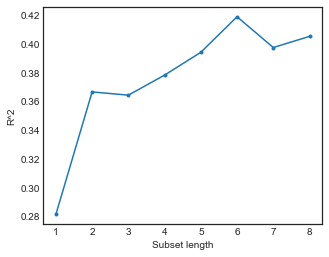

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.plot(range(1,9), list_scores, '.-')
ax.set_xlabel('Subset length')
ax.set_ylabel('R^2');

### 6.5.2 Forward and Backward Stepwise Selection

In [ ]:
# TODO
def forward_stepwise(estimator, X, y, cv=5):
    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            estimator.fit(X.iloc[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X.iloc[:, list(subset)], y)
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)
        
    # compare best subsets of each size
    best_score = -np.inf
    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        score = cross_val_score(estimator, X.iloc[:, list(subset)], y, cv=cv).mean()
        list_scores.append(score)
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score, best_size_subset, list_scores